# Testing isostatic boundary conditions in UW2

The setup is:

     <--------- 100 km ------------>
    _________________________________
    |                               |  ^
    |                               |  |
    |     incompressible air        |  50 km 
    |        1 kg.m^-3              |  |
    |                               |  | 
    |_______________________________|  v 
    |crust    | weaker  |  crust    |  ^ 
    |500 kg.  | crust   |           |  25 km 
    |_________|_________|___________|  v 
    |        mantle                 |  ^ 
    |        1000 kg.m^-3           |  25 km 
    |_______________________________|  v 


This is the same setup as the Isostasy 2 - Weaker blob model, but it now has sedimentation.

In this model, we use the LecodeIsostasy boundary condition.

In [1]:
import underworld as uw
import UWGeodynamics as GEO
import numpy as np
import matplotlib.pyplot as plt

from UWGeodynamics.surfaceProcesses import SedimentationThreshold

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry
GEO.rcParams['solver'] = "mumps"
GEO.rcParams["surface.pressure.normalization"] = True

# must be 0, because we use compressible air
GEO.rcParams["penalty"] = 0

# Use some higher order elements to get a nicer solution
GEO.rcParams["element.type"] = "Q2/dQ1"

# Use the fancier advection diffusion method
GEO.rcParams["advection.diffusion.method"] = "SLCN"

# Normally this is 0.5, but it can make it easier for the solver if you reduce this number.
GEO.rcParams["CFL"] = 0.25

# Adjust how particles populate the model. Because this model has a big load of inflowing material,
# I like to have these very aggressive
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 60
GEO.rcParams["swarm.particles.per.cell.2D"] = 60

In [3]:
GEO.rcParams["output.directory"] = "simple_isos_1"

In [4]:
# This is all for scaling the model
# most of it is pretty self explanitory, try to make them match your setup as best as possible
half_rate = 1.0 * u.centimeter / u.year
model_length = 100e3 * u.meter
model_height = 100e3 * u.meter
refViscosity = 1e22 * u.pascal * u.second
bodyforce = 500 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [5]:
# Setup the model domain and resolution. The 'divisor' is just an easy way to adjust the resolution
divisor = 4
Model = GEO.Model(elementRes=(int(100/divisor),int(100/divisor)), 
                  minCoord=(-50 * u.kilometer, -50 * u.kilometer),
                  maxCoord=( 50 * u.kilometer,  50 * u.kilometer))

In [6]:
air      = Model.add_material(name="air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=0.0))
uc       =  Model.add_material(name="crust",  shape=GEO.shapes.Layer2D(top=air.bottom, bottom=-25*u.kilometer))
weakzone =  Model.add_material(name="weak",  shape=GEO.shapes.Box(minX=-12.5*u.kilometer, maxX=12.5*u.kilometer, top=air.bottom, bottom=-25*u.kilometer))
mantle   = Model.add_material(name="mantle",  shape=GEO.shapes.Layer2D(top=uc.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="sediment")

# We use 'easy' numbers here, so the analytical calculation is easier.
air.density       =    1. * u.kilogram / u.metre**3
sediment.density  =  500. * u.kilogram / u.metre**3
uc.density        =  500. * u.kilogram / u.metre**3
weakzone.density  =  500. * u.kilogram / u.metre**3
mantle.density    = 1000. * u.kilogram / u.metre**3


air.viscosity      = 1e19 * u.pascal * u.second
uc.viscosity       = 1e21 * u.pascal * u.second
weakzone.viscosity = 2e20 * u.pascal * u.second
mantle.viscosity   = 1e20 * u.pascal * u.second
sediment.viscosity = 1e21 * u.pascal * u.second 

In [7]:
# So here we set the threshold to be 0 km. That means when the crust thins, and hence subsides, it is immediately
# replaced by sediment material. We therefor expect by the end of the model to have entirely replaced the crust
# and we should see 25 km of mantle, with 25 km of sediment on top.
Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(
    air=[air], 
    sediment=[sediment], 
    threshold=0.*u.kilometer)

In [8]:
# We need to initialise the model before calculating anything to serious (like the lithostatic pressure)
Model.init_model()


# This is where we apply the boundary conditions. As a rule of thumb, the more information we can give to UW, the happier
# it will be. For example, we could make the top a free slip condition:
#     top=[None , 0. * u.centimetre / u.year]
# but really, we don't care much about the top of the air, so giving 'extra info' in the form of a no-slip condition
# helps UW figure out what's going on.
# Try removing various bits of information to compare how the model performs.
Model.set_velocityBCs(left   = [-1.0 * u.centimetre / u.year, 0 * u.centimetre / u.year], 
                      right  = [1.0 * u.centimetre / u.year,  0 * u.centimetre / u.year], 
                      bottom = GEO.LecodeIsostasy(reference_mat=mantle.index))

In [9]:
# This is a bunch of solver options. You can try playing with them, but these should be good enough.
Model.solver = Model.stokes_solver()
Model.solver.options.A11.ksp_rtol=1e-8
Model.solver.options.scr.ksp_rtol=1e-8
Model.solver.options.scr.use_previous_guess = True
Model.solver.options.scr.ksp_set_min_it_converge = 10
Model.solver.options.scr.ksp_type = "cg"
Model.solver.options.main.remove_constant_pressure_null_space=True


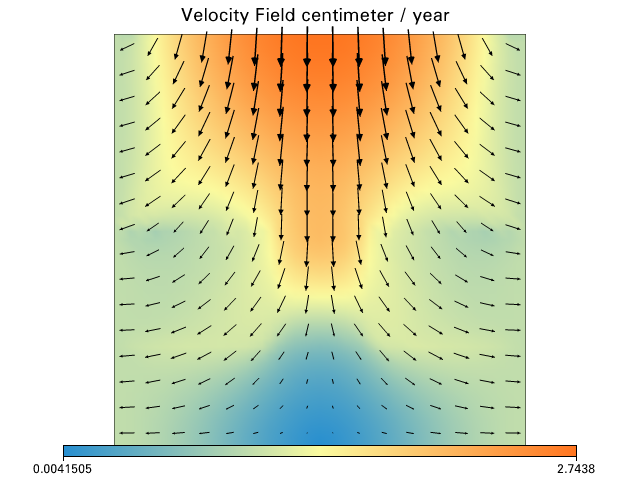


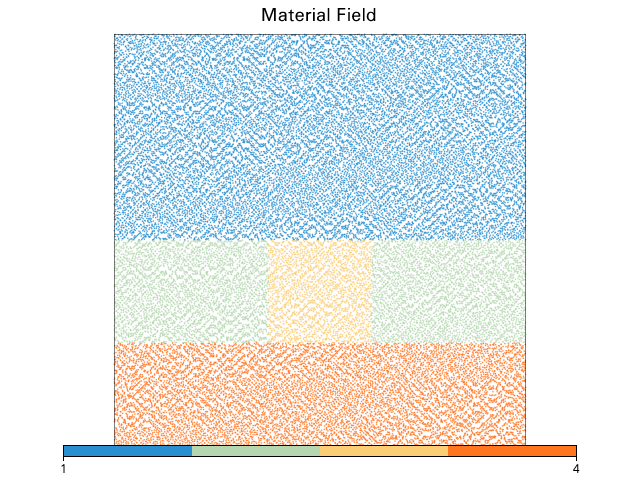

In [10]:
# Do an initial solve to give us a look at what's happening.
Model.solve()
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

## Run model in a few increments, and show the results

In [11]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  9111.574579022394 year dt: 9111.574579022394 year (2018-10-25 05:24:57)
Step:2 Model Time:  23908.769359656402 year dt: 14797.194780634009 year (2018-10-25 05:24:58)
Step:3 Model Time:  38778.25985265933 year dt: 14869.490493002926 year (2018-10-25 05:24:58)
Step:4 Model Time:  53649.15024313158 year dt: 14870.89039047226 year (2018-10-25 05:24:59)
Step:5 Model Time:  68498.55874822641 year dt: 14849.408505094834 year (2018-10-25 05:24:59)
Step:6 Model Time:  83329.10148265967 year dt: 14830.542734433247 year (2018-10-25 05:25:00)
Step:7 Model Time:  98179.73166357499 year dt: 14850.630180915328 year (2018-10-25 05:25:00)
Step:8 Model Time:  113037.11589422391 year dt: 14857.384230648913 year (2018-10-25 05:25:01)
Step:9 Model Time:  127898.23595561928 year dt: 14861.120061395359 year (2018-10-25 05:25:01)
Step:10 Model Time:  142739.800610051 year dt: 14841.564654431719 year (2018-10-25 05:25:01)
Ste

Step:88 Model Time:  1338581.0578648625 year dt: 15767.522515310204 year (2018-10-25 05:25:37)
Step:89 Model Time:  1354358.6990742914 year dt: 15777.641209428908 year (2018-10-25 05:25:38)
Step:90 Model Time:  1370115.4113180926 year dt: 15756.71224380143 year (2018-10-25 05:25:38)
Step:91 Model Time:  1385938.2086156963 year dt: 15822.797297603636 year (2018-10-25 05:25:39)
Step:92 Model Time:  1401797.7139752798 year dt: 15859.505359583403 year (2018-10-25 05:25:39)
Step:93 Model Time:  1417649.7674068771 year dt: 15852.053431597318 year (2018-10-25 05:25:39)
Step:94 Model Time:  1433464.3859546855 year dt: 15814.618547808197 year (2018-10-25 05:25:40)
Step:95 Model Time:  1449296.0249212824 year dt: 15831.638966597166 year (2018-10-25 05:25:40)
Step:96 Model Time:  1465122.9250607498 year dt: 15826.900139467225 year (2018-10-25 05:25:41)
Step:97 Model Time:  1480949.7946767826 year dt: 15826.869616032965 year (2018-10-25 05:25:41)
Step:98 Model Time:  1496779.350749428 year dt: 158

1


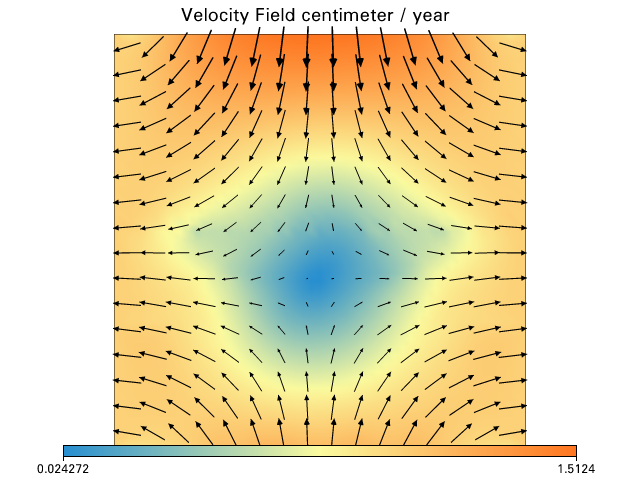


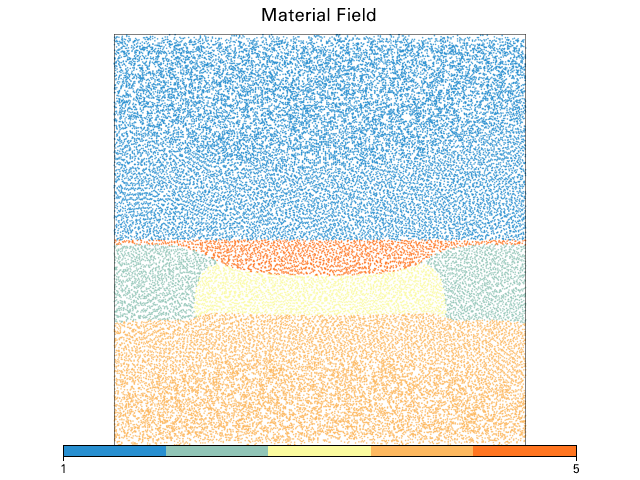

In [12]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [13]:
Model.run_for(2.5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  2516552.0199960787 year dt: 16552.019996078878 year (2018-10-25 05:26:13)
Step:2 Model Time:  2533080.442148077 year dt: 16528.42215199789 year (2018-10-25 05:26:13)
Step:3 Model Time:  2549645.0570928594 year dt: 16564.6149447825 year (2018-10-25 05:26:13)
Step:4 Model Time:  2566203.214837634 year dt: 16558.157744774733 year (2018-10-25 05:26:14)
Step:5 Model Time:  2582796.4268996697 year dt: 16593.2120620353 year (2018-10-25 05:26:14)
Step:6 Model Time:  2599341.049091069 year dt: 16544.622191399594 year (2018-10-25 05:26:15)
Step:7 Model Time:  2615884.372199184 year dt: 16543.32310811479 year (2018-10-25 05:26:15)
Step:8 Model Time:  2632438.128475237 year dt: 16553.756276053184 year (2018-10-25 05:26:16)
Step:9 Model Time:  2649024.2848987505 year dt: 16586.15642351349 year (2018-10-25 05:26:16)
Step:10 Model Time:  2665624.667309483 year dt: 16600.38241073255 year (2018-10-25 05:26:17)
Step:11

Step:88 Model Time:  3988144.0672085364 year dt: 17128.27899326868 year (2018-10-25 05:26:52)
Step:89 Model Time:  4005242.9849636033 year dt: 17098.91775506656 year (2018-10-25 05:26:52)
Step:90 Model Time:  4022363.5308502726 year dt: 17120.54588666953 year (2018-10-25 05:26:53)
Step:91 Model Time:  4039433.9501849297 year dt: 17070.419334656828 year (2018-10-25 05:26:53)
Step:92 Model Time:  4056524.4252029816 year dt: 17090.475018051762 year (2018-10-25 05:26:54)
Step:93 Model Time:  4073612.5410126504 year dt: 17088.11580966914 year (2018-10-25 05:26:54)
Step:94 Model Time:  4090720.2651688834 year dt: 17107.724156232664 year (2018-10-25 05:26:55)
Step:95 Model Time:  4107841.70982679 year dt: 17121.44465790654 year (2018-10-25 05:26:55)
Step:96 Model Time:  4125009.9701935523 year dt: 17168.260366762308 year (2018-10-25 05:26:55)
Step:97 Model Time:  4142156.0468800943 year dt: 17146.07668654164 year (2018-10-25 05:26:56)
Step:98 Model Time:  4159293.264792458 year dt: 17137.2179

1


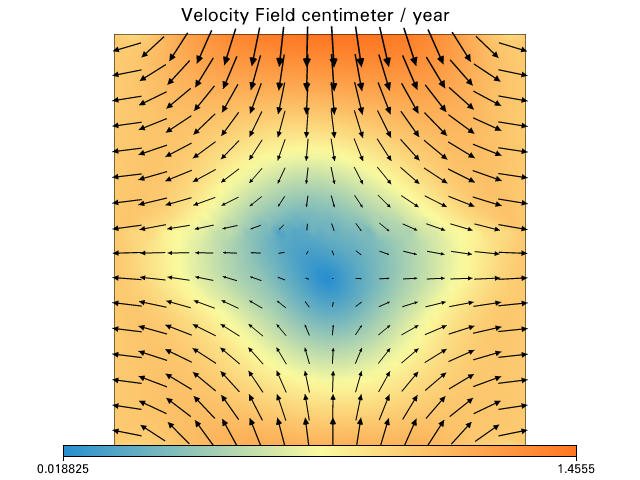


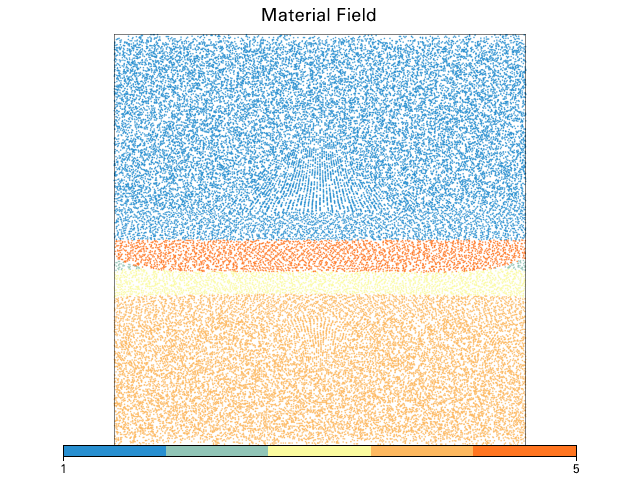

In [14]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [15]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  5017330.566981347 year dt: 17330.566981344087 year (2018-10-25 05:27:21)
Step:2 Model Time:  5034623.152258547 year dt: 17292.58527719972 year (2018-10-25 05:27:21)
Step:3 Model Time:  5051892.751485385 year dt: 17269.599226837796 year (2018-10-25 05:27:22)
Step:4 Model Time:  5069123.812479547 year dt: 17231.060994162228 year (2018-10-25 05:27:22)
Step:5 Model Time:  5086413.052922704 year dt: 17289.240443157105 year (2018-10-25 05:27:23)
Step:6 Model Time:  5103575.022009647 year dt: 17161.969086944093 year (2018-10-25 05:27:23)
Step:7 Model Time:  5120871.504722142 year dt: 17296.482712493686 year (2018-10-25 05:27:24)
Step:8 Model Time:  5138164.638964138 year dt: 17293.134241997002 year (2018-10-25 05:27:24)
Step:9 Model Time:  5155391.444252901 year dt: 17226.805288762906 year (2018-10-25 05:27:25)
Step:10 Model Time:  5172647.909644219 year dt: 17256.465391318223 year (2018-10-25 05:27:25)
Step

Step:88 Model Time:  6529628.796302039 year dt: 17609.834035268745 year (2018-10-25 05:28:00)
Step:89 Model Time:  6547200.206332473 year dt: 17571.41003043341 year (2018-10-25 05:28:00)
Step:90 Model Time:  6564754.269163144 year dt: 17554.062830670922 year (2018-10-25 05:28:01)
Step:91 Model Time:  6582247.4840959925 year dt: 17493.21493284834 year (2018-10-25 05:28:01)
Step:92 Model Time:  6599721.453730753 year dt: 17473.969634760935 year (2018-10-25 05:28:01)
Step:93 Model Time:  6617204.969116289 year dt: 17483.51538553626 year (2018-10-25 05:28:02)
Step:94 Model Time:  6634759.966747631 year dt: 17554.99763134195 year (2018-10-25 05:28:02)
Step:95 Model Time:  6652339.854028018 year dt: 17579.88728038751 year (2018-10-25 05:28:03)
Step:96 Model Time:  6669847.776917161 year dt: 17507.922889142712 year (2018-10-25 05:28:03)
Step:97 Model Time:  6687456.345203498 year dt: 17608.56828633702 year (2018-10-25 05:28:04)
Step:98 Model Time:  6705020.722344277 year dt: 17564.37714077871

Step:175 Model Time:  8089529.807656835 year dt: 18338.967953686177 year (2018-10-25 05:28:38)
Step:176 Model Time:  8107831.921382136 year dt: 18302.113725300736 year (2018-10-25 05:28:38)
Step:177 Model Time:  8125896.7486546915 year dt: 18064.827272555933 year (2018-10-25 05:28:39)
Step:178 Model Time:  8143979.976884209 year dt: 18083.228229517623 year (2018-10-25 05:28:39)
Step:179 Model Time:  8162273.052747342 year dt: 18293.07586313331 year (2018-10-25 05:28:40)
Step:180 Model Time:  8180559.047519264 year dt: 18285.994771921953 year (2018-10-25 05:28:40)
Step:181 Model Time:  8198809.603809368 year dt: 18250.5562901033 year (2018-10-25 05:28:41)
Step:182 Model Time:  8217099.719377236 year dt: 18290.11556786885 year (2018-10-25 05:28:41)
Step:183 Model Time:  8235330.875299201 year dt: 18231.155921965754 year (2018-10-25 05:28:42)
Step:184 Model Time:  8253710.356671698 year dt: 18379.481372497507 year (2018-10-25 05:28:42)
Step:185 Model Time:  8272097.744579831 year dt: 1838

Step:262 Model Time:  9683257.708481323 year dt: 18574.072442197034 year (2018-10-25 05:29:17)
Step:263 Model Time:  9701888.196490781 year dt: 18630.488009457797 year (2018-10-25 05:29:18)
Step:264 Model Time:  9720492.949502356 year dt: 18604.753011575427 year (2018-10-25 05:29:18)
Step:265 Model Time:  9738948.22493884 year dt: 18455.275436483433 year (2018-10-25 05:29:19)
Step:266 Model Time:  9757495.70990861 year dt: 18547.48496977053 year (2018-10-25 05:29:19)
Step:267 Model Time:  9775800.69925907 year dt: 18304.989350460328 year (2018-10-25 05:29:20)
Step:268 Model Time:  9794327.314209424 year dt: 18526.61495035312 year (2018-10-25 05:29:20)
Step:269 Model Time:  9812753.571168268 year dt: 18426.256958846032 year (2018-10-25 05:29:21)
Step:270 Model Time:  9831292.844824605 year dt: 18539.273656335856 year (2018-10-25 05:29:21)
Step:271 Model Time:  9849813.162938971 year dt: 18520.318114367034 year (2018-10-25 05:29:21)
Step:272 Model Time:  9868420.551316489 year dt: 18607.

1


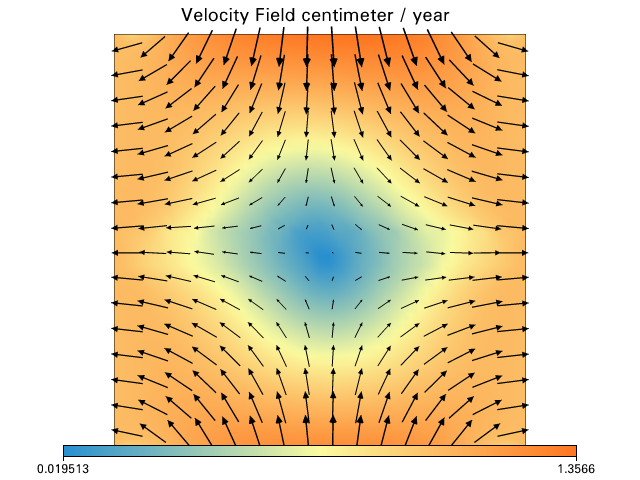


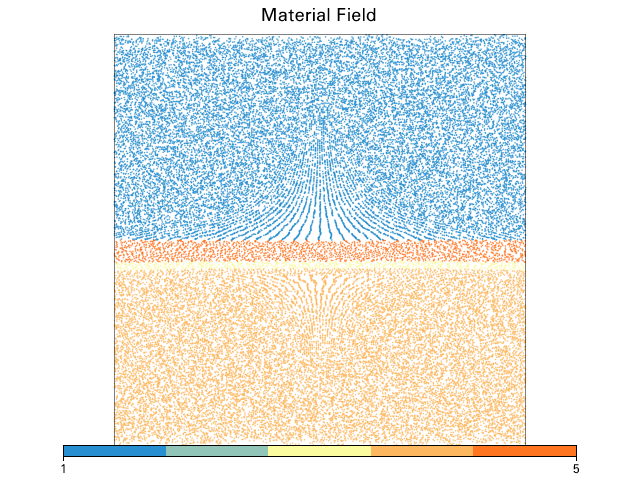

In [16]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)

In [17]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  10018449.44238383 year dt: 18449.442383820697 year (2018-10-25 05:29:28)
Step:2 Model Time:  10036847.382246265 year dt: 18397.939862434694 year (2018-10-25 05:29:28)
Step:3 Model Time:  10055165.536155587 year dt: 18318.15390932154 year (2018-10-25 05:29:29)
Step:4 Model Time:  10073524.55655713 year dt: 18359.020401543716 year (2018-10-25 05:29:29)
Step:5 Model Time:  10092008.65863059 year dt: 18484.102073462287 year (2018-10-25 05:29:29)
Step:6 Model Time:  10110238.296033924 year dt: 18229.637403332843 year (2018-10-25 05:29:30)
Step:7 Model Time:  10128879.530465456 year dt: 18641.234431530294 year (2018-10-25 05:29:30)
Step:8 Model Time:  10147515.97136418 year dt: 18636.440898724406 year (2018-10-25 05:29:31)
Step:9 Model Time:  10166067.17983275 year dt: 18551.20846856892 year (2018-10-25 05:29:31)
Step:10 Model Time:  10184647.22098594 year dt: 18580.041153189697 year (2018-10-25 05:29:32)
S

Step:88 Model Time:  11645011.301737554 year dt: 18819.69351538282 year (2018-10-25 05:30:07)
Step:89 Model Time:  11663882.175141973 year dt: 18870.873404419126 year (2018-10-25 05:30:07)
Step:90 Model Time:  11682727.187734803 year dt: 18845.012592830073 year (2018-10-25 05:30:08)
Step:91 Model Time:  11701606.659288155 year dt: 18879.47155335115 year (2018-10-25 05:30:08)
Step:92 Model Time:  11720502.358168738 year dt: 18895.69888058213 year (2018-10-25 05:30:09)
Step:93 Model Time:  11739421.2097319 year dt: 18918.85156316212 year (2018-10-25 05:30:09)
Step:94 Model Time:  11758379.624378793 year dt: 18958.414646894194 year (2018-10-25 05:30:10)
Step:95 Model Time:  11777192.7941221 year dt: 18813.169743304898 year (2018-10-25 05:30:10)
Step:96 Model Time:  11796108.609644357 year dt: 18915.815522256908 year (2018-10-25 05:30:11)
Step:97 Model Time:  11815008.479388349 year dt: 18899.86974399111 year (2018-10-25 05:30:11)
Step:98 Model Time:  11833873.214780744 year dt: 18864.7353

Step:174 Model Time:  13258027.212210592 year dt: 18633.55233386919 year (2018-10-25 05:30:46)
Step:175 Model Time:  13276669.597609257 year dt: 18642.38539866603 year (2018-10-25 05:30:46)
Step:176 Model Time:  13295371.074688781 year dt: 18701.477079522105 year (2018-10-25 05:30:47)
Step:177 Model Time:  13314096.931231648 year dt: 18725.85654286668 year (2018-10-25 05:30:47)
Step:178 Model Time:  13332804.683017917 year dt: 18707.75178626923 year (2018-10-25 05:30:47)
Step:179 Model Time:  13351382.82879589 year dt: 18578.14577797254 year (2018-10-25 05:30:48)
Step:180 Model Time:  13369956.805411404 year dt: 18573.97661551338 year (2018-10-25 05:30:48)
Step:181 Model Time:  13388496.407625224 year dt: 18539.602213821534 year (2018-10-25 05:30:49)
Step:182 Model Time:  13407096.802822288 year dt: 18600.395197063717 year (2018-10-25 05:30:49)
Step:183 Model Time:  13425762.10600051 year dt: 18665.303178220034 year (2018-10-25 05:30:50)
Step:184 Model Time:  13444474.638604987 year dt

Step:260 Model Time:  14873550.620765382 year dt: 18965.36828133395 year (2018-10-25 05:31:25)
Step:261 Model Time:  14892562.620980892 year dt: 19012.000215511573 year (2018-10-25 05:31:25)
Step:262 Model Time:  14911375.047276365 year dt: 18812.426295471338 year (2018-10-25 05:31:26)
Step:263 Model Time:  14930262.870563526 year dt: 18887.823287162104 year (2018-10-25 05:31:26)
Step:264 Model Time:  14948887.031633964 year dt: 18624.1610704386 year (2018-10-25 05:31:27)
Step:265 Model Time:  14967859.336051816 year dt: 18972.304417851767 year (2018-10-25 05:31:27)
Step:266 Model Time:  14986684.206110334 year dt: 18824.870058517263 year (2018-10-25 05:31:28)
Step:267 Model Time:  15000000.0 year dt: 13315.793889665529 year (2018-10-25 05:31:28)


1


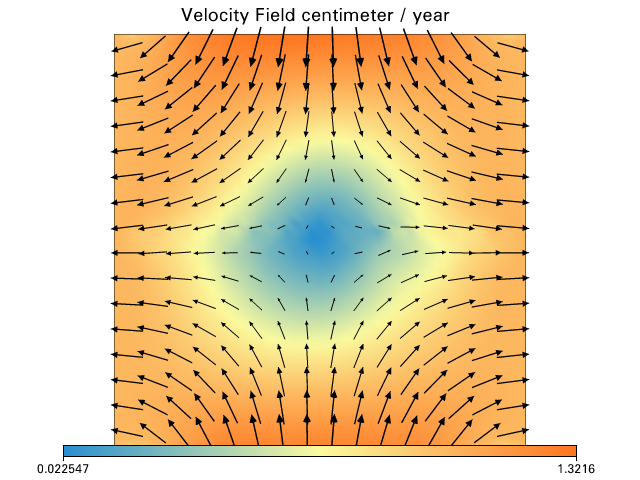


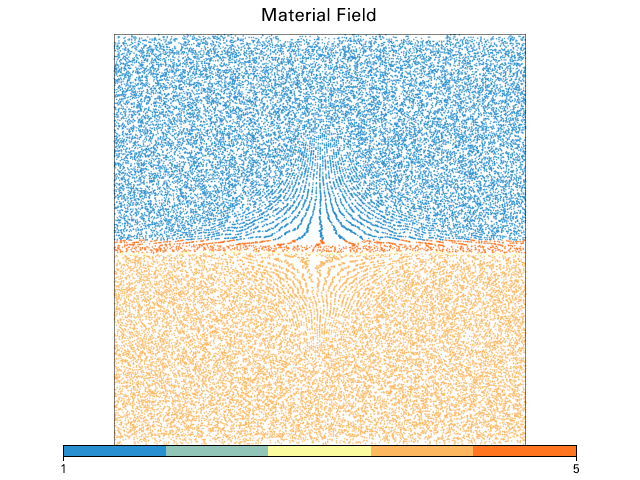

In [18]:
Fig = Model.plot.velocityField()
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [19]:
Model.run_for(5e6* u.year)

Running with UWGeodynamics version 0.9.3-dev-c8e8e8a(development)
Step:1 Model Time:  15019039.425900318 year dt: 19039.42590031669 year (2018-10-25 05:31:30)
Step:2 Model Time:  15037986.324995186 year dt: 18946.899094869936 year (2018-10-25 05:31:31)
Step:3 Model Time:  15056740.802856242 year dt: 18754.47786105502 year (2018-10-25 05:31:31)
Step:4 Model Time:  15075765.601649107 year dt: 19024.798792865713 year (2018-10-25 05:31:32)
Step:5 Model Time:  15094728.60105791 year dt: 18962.9994088008 year (2018-10-25 05:31:32)
Step:6 Model Time:  15113669.982649803 year dt: 18941.381591894464 year (2018-10-25 05:31:33)
Step:7 Model Time:  15132665.658823265 year dt: 18995.676173462325 year (2018-10-25 05:31:33)
Step:8 Model Time:  15151675.980703255 year dt: 19010.321879989777 year (2018-10-25 05:31:34)
Step:9 Model Time:  15170690.18159957 year dt: 19014.200896315146 year (2018-10-25 05:31:34)
Step:10 Model Time:  15189426.82332363 year dt: 18736.641724061636 year (2018-10-25 05:31:34)


Step:88 Model Time:  16667003.930722857 year dt: 19021.310098904338 year (2018-10-25 05:32:09)
Step:89 Model Time:  16686099.157590775 year dt: 19095.22686791738 year (2018-10-25 05:32:09)
Step:90 Model Time:  16704986.854456063 year dt: 18887.69686528829 year (2018-10-25 05:32:10)
Step:91 Model Time:  16724173.93108075 year dt: 19187.076624685942 year (2018-10-25 05:32:10)
Step:92 Model Time:  16743276.42963004 year dt: 19102.498549292482 year (2018-10-25 05:32:11)
Step:93 Model Time:  16762170.89459204 year dt: 18894.4649619976 year (2018-10-25 05:32:11)
Step:94 Model Time:  16781243.466578577 year dt: 19072.57198653666 year (2018-10-25 05:32:12)
Step:95 Model Time:  16800362.406163827 year dt: 19118.939585251577 year (2018-10-25 05:32:12)
Step:96 Model Time:  16819393.369672857 year dt: 19030.963509026817 year (2018-10-25 05:32:13)
Step:97 Model Time:  16838549.97269038 year dt: 19156.60301752284 year (2018-10-25 05:32:13)
Step:98 Model Time:  16857513.850301243 year dt: 18963.87761

Step:175 Model Time:  18330263.797379225 year dt: 19063.554270790475 year (2018-10-25 05:32:48)
Step:176 Model Time:  18349097.033632 year dt: 18833.236252775856 year (2018-10-25 05:32:48)
Step:177 Model Time:  18368165.041765247 year dt: 19068.008133246 year (2018-10-25 05:32:49)
Step:178 Model Time:  18386849.772881772 year dt: 18684.73111652588 year (2018-10-25 05:32:49)
Step:179 Model Time:  18406024.958737787 year dt: 19175.18585601854 year (2018-10-25 05:32:50)
Step:180 Model Time:  18425363.181683946 year dt: 19338.222946157643 year (2018-10-25 05:32:50)
Step:181 Model Time:  18444554.10800661 year dt: 19190.926322664218 year (2018-10-25 05:32:50)
Step:182 Model Time:  18463727.513626378 year dt: 19173.405619766534 year (2018-10-25 05:32:51)
Step:183 Model Time:  18482886.348243143 year dt: 19158.834616764096 year (2018-10-25 05:32:51)
Step:184 Model Time:  18502021.60125721 year dt: 19135.25301406838 year (2018-10-25 05:32:52)
Step:185 Model Time:  18521137.370299093 year dt: 1

Step:262 Model Time:  19995506.602027204 year dt: 19281.68572647537 year (2018-10-25 05:33:26)
Step:263 Model Time:  19999999.999999996 year dt: 4493.397972795688 year (2018-10-25 05:33:27)


1


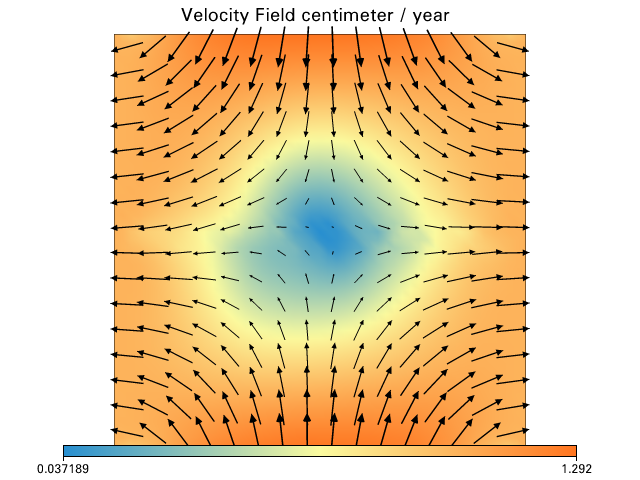


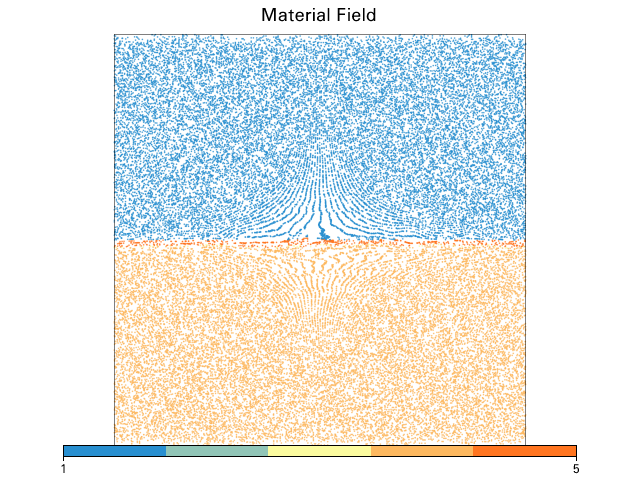

In [20]:
Fig = Model.plot.velocityField(rulers=True, rulerticks=5)
Fig = Model.plot.material(projected=False, fn_size=2.0,rulers=True, rulerticks=5)

# Summary

We can see that the LecodeIsostasy boundary condition **does not** handle the sedimentation well, and the model ends up with the mantle far to high.